In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_circles
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import accuracy_score

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

## Реализация дерева решений<a class='anchor' id='implement_dt'>

Реализуем алгоритм алгоритм работы дерева решений своими руками.

In [2]:
# сгенерируем данные
classification_data, classification_labels = make_classification(n_features=2, n_informative=2, 
                                                                 n_classes=2, n_redundant=0,
                                                                 n_clusters_per_class=1, random_state=5)
classification_data, classification_labels = make_circles(n_samples=30, random_state=5)

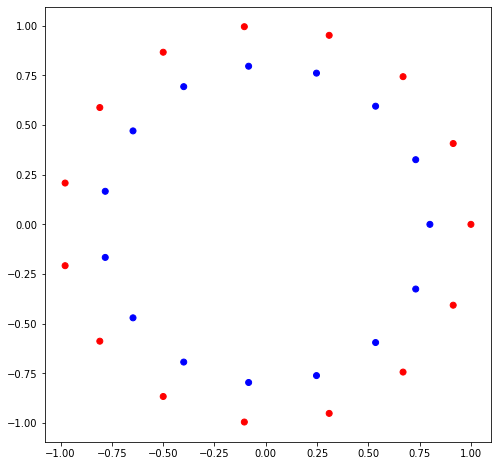

In [3]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors);

In [4]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [5]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

$$H(X) = \sum^{K}_{k=1}p_{k}(1-p_{k}) = 1 - \sum_{k=1}^K{p_k^2} ,$$


In [6]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

$$H(X_{m}) - \frac{|X_{l}|}{|X_{m}|}H(X_{l}) - \frac{|X_{r}|}{|X_{m}|}H(X_{r}),$$


In [7]:
# Расчет прироста

def gain(left_labels, right_labels, root_gini):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [8]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [9]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_samples_leaf = 5

    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                continue
            
            current_gain = gain(true_labels, false_labels, root_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

## Домашнее задание<a class='anchor' id='hw'>

1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.)

Реализую критерий останова глубины дерева, добавлю параметр глубины и счетчик

In [10]:
import time

# Построение дерева с помощью рекурсивной функции
def build_tree(data, labels, depth, counter=0):
    gain, t, index = find_best_split(data, labels)
    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    #  Добавляю параметр глубины ограничивающий рекурсию и добавил счетчик как параметр по умолчанию в нуле
    if gain == 0 or counter == depth:
        return Leaf(data, labels)
    #Инкрементирую счетчик после условия, чтобы хотя бы раз функция отработала в рекурсии
    counter += 1
    #print(counter)
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, depth, counter)

#     print(time.time(), true_branch)
    false_branch = build_tree(false_data, false_labels, depth, counter)

#     print(time.time(), false_branch)
    
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [11]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [12]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [13]:
# Разобьем выборку на обучающую и тестовую

from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size=0.3,
                                                                    random_state=1)

In [14]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels, 2)

In [15]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index), '<=', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print(spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print(spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 1 <= -0.40673664307580093
--> True:
  Прогноз: 0
--> False:
  Индекс 1 <= 0.5945158603819153
  --> True:
    Прогноз: 1
  --> False:
    Прогноз: 0


In [16]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [17]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [18]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [19]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

71.42857142857143

In [20]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

22.22222222222222

In [21]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


def visualize(train_data, test_data):
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')

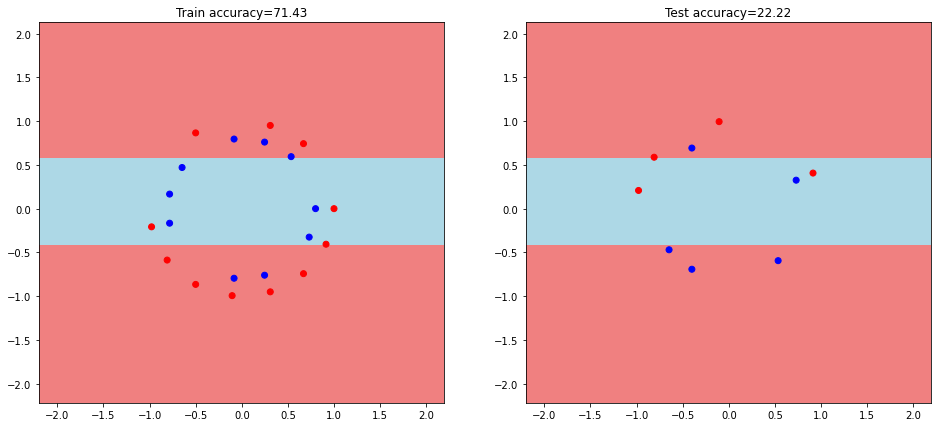

In [22]:
visualize(train_data, test_data)

Как видно, дерево строит кусочно-постоянную разделяющую гиперплоскость, то есть состоящую из прямых, параллельных осям. Чем глубже дерево, тем сложнее гиперплоскость. Также происходит и в случае регрессии - график зависимости целевого значения восстанавливается кусочно-постоянной функцией.

### Пример с датасетом сердечно-сосудистых заболеваний

In [23]:
df_full = pd.read_csv('./data/cardio.csv', sep=';')

features = ['age', 'height']
target = ['cardio']

df = df_full[features + target]
print(df.shape)

train_data, test_data, train_labels, test_labels = train_test_split(df[features].values, 
                                                                    np.squeeze(df[target].values),
                                                                    test_size=0.3,
                                                                    random_state=1)

(70000, 3)


In [24]:
%%time

my_tree = build_tree(train_data, train_labels, 20)

Wall time: 7.57 s


In [25]:
print_tree(my_tree)

Индекс 0 <= 54
--> True:
  Индекс 0 <= 44
  --> True:
    Индекс 0 <= 40
    --> True:
      Индекс 1 <= 159
      --> True:
        Индекс 1 <= 152
        --> True:
          Индекс 0 <= 39
          --> True:
            Индекс 1 <= 151
            --> True:
              Индекс 1 <= 146
              --> True:
                Индекс 1 <= 142
                --> True:
                  Прогноз: 0
                --> False:
                  Прогноз: 0
              --> False:
                Индекс 1 <= 149
                --> True:
                  Прогноз: 0
                --> False:
                  Индекс 1 <= 150
                  --> True:
                    Прогноз: 0
                  --> False:
                    Прогноз: 0
            --> False:
              Прогноз: 0
          --> False:
            Индекс 1 <= 148
            --> True:
              Прогноз: 0
            --> False:
              Индекс 1 <= 150
              --> True:
                Прогноз: 0
 

In [26]:
train_answers = predict(train_data, my_tree)
test_answers = predict(test_data, my_tree)

In [27]:
train_accuracy = accuracy_metric(train_labels, train_answers)
test_accuracy = accuracy_metric(test_labels, test_answers)

print(f'Train accuracy', train_accuracy)
print(f'Test accuracy', test_accuracy)

Train accuracy 61.381632653061224
Test accuracy 58.34285714285714


Wall time: 9.75 s


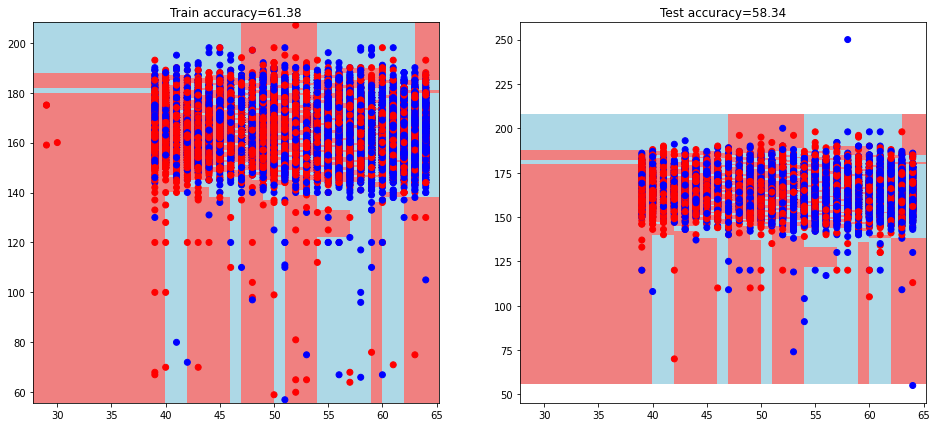

In [28]:
%%time
visualize(train_data, test_data)

In [29]:
dt = DecisionTreeClassifier()
dt.fit(train_data, train_labels)

train_answers = dt.predict(train_data)
test_answers = dt.predict(test_data)

train_accuracy = accuracy_metric(train_labels, train_answers)
test_accuracy = accuracy_metric(test_labels, test_answers)

print(f'Train accuracy', train_accuracy)
print(f'Test accuracy', test_accuracy)

Train accuracy 61.559183673469384
Test accuracy 58.352380952380955


In [30]:
accuracy_score(train_answers, train_labels) * 100

61.559183673469384

## Работа деревьев в случае пропущенных значений<a class='anchor' id='nan'>

Иногда в реальных задачах бывает так, что не для всех объектов известно значение того или иного признака. Одним из преимуществ деревьев решений является возможность обрабатывать такие случаи.

Допустим, требуется вычислить функционал качества для разбиения $[x_{j} \leq t]$, но в выборке $X_{m}$ для некоторого подмножества объектов $V_{j}$ неизвестно значение $j$-го признака. В этом случае функционал качества рассчитывается без учета этих объектов (обозначим выборку без их учета как $X_{m}\text{\ }V_{j}$), с поправкой на потерю информации:

$$Q_{X_{m}, j, t} = \frac{|X_{m}\text{\ } V_{j}|}{|X_{m}|}Q(X_{m}\text{\ }V_{j}, j,t).$$

Если такое разбиение окажется лучшим, объекты из $V_{j}$ помещаются в оба образованных поддерева.

На этапе применения дерева выполняется похожая операция. Если объект попал в вершину, в которой нельзя вычислить критерий разбиения из-за отсутствия значения необходимого признака, прогнозы для него вычисляются в обоих поддеревьях, а затем усредняются с весами, пропорциональными числу объектов в них.

$$\frac{|X_{l}|}{|X_{m}|}a_{l}(x) + \frac{|X_{r}|}{|X_{m}|}a_{r}(x),$$

где $a$ - прогноз веорятности отнесения объекта $x$ к одному из классов.

**Добавим в выборку пропущенные значения**

In [31]:
random_indices = np.random.randint(0, df.shape[0], 1000)
df.loc[random_indices, ['height']] = np.nan
df.isna().sum()

age         0
height    997
cardio      0
dtype: int64

**Получим значения критерия Джини**

In [32]:
root_gini = gini(df['height'])
root_gini

0.959834727755094

In [33]:
t = df['height'].median()

df_clean = df[~df['height'].isna()]

In [34]:
df1 = df_clean[df_clean['height'] <= t]
df2 = df_clean[df_clean['height'] > t]

In [35]:
gini1 = gini(df1['cardio'])
gini2 = gini(df2['cardio'])
gini1, gini2

(0.49999005966175847, 0.49997853853466423)

**Получим значение прироста информации**

In [36]:
current_gain = gain(df1['cardio'], df2['cardio'], root_gini)
current_gain

0.45984956118712317

**Сделаем поправку на потерю информации**

In [37]:
df_clean.shape[0] / df.shape[0] * current_gain

0.45329998957992945

**Если разбиение лучшее, то наблюдения с nan добавляются в обе ветки**

In [38]:
df1 = df1.append(df[df['height'].isna()])
df2 = df2.append(df[df['height'].isna()])

## Работа деревьев с категориальными признаками<a class='anchor' id='cats'>

Кроме вещественных и бинарных признаков в задаче могут иметь место категориальные признаки (делящиеся на конечное число категорий, например, цвета автомобилей). Самый простой способ учета категориальных признаков в алгоритме деревьев состоит в разбитии вершины на столько поддеревьев, сколько имеется возможных значений признака. В этом случае дерево называется _n-арным_. Условие разбиения будет простым (отнесение признака к той или иной категории), однако здесь появляется риск получения конечного дерева с очень большим числом листьев. В случае такого дерева критерий ошибки $Q$ будет состоять из $n$ слагаемых (или из $(n+1)$) в случае максимизируемого критерия, который мы использовали.

Есть и другой подход, заключающийся в формировании бинарных деревьев путем разделения множества значений признака $C = \{c_{1}, ...,c_{n}\}$ на два непересекающихся подмножества $C_{1}$ и $C_{2}$. После такого разделения условием разбиения в узле будет проверка принадлежности признака одному из подмножеств $[x \in C_{1}]$.

Задача остается в выборе оптимального варианта разбиения исходного множества на два подмножества, так как обычный перебор всех вариантов может быть крайне затруднительным из-за большого количества вариантов разбиения. В случаях с бинарной классификацией и регрессией используют следующий метод: все возможные значения категориального признака сортируются по определенному принципу, затем заменяются на натуральные числа.

В случае бинарной классификации признаки упорядочиваются на основе того, какая доля объектов с такими признаками относится к классу +1. Если обозначить множество объектов в узле $m$, у которых $j$-й признак имеет значение $с$, через $X_{m}(c)$, а через $N_{m}(c)$ количество таких объектов, получим:

$$\frac{1}{N_{m}(c_{1})} \sum_{x \in X_{m}(c_{1})}[y_{i}=+1]\leq...\leq \frac{1}{N_{m}(c_{n})} \sum_{x \in X_{m}(c_{n})}[y_{i}=+1],$$

и после замены категории $c_{i}$ на натуральное число ищется разбиение как для вещественного признака.

В случае задачи регрессии сортировка происходит схожим образом, но вместо доли объектов положительного класса среди объектов с таким значением признака вычисляется средний ответ по объектам с соответствующим значением категориального признака:

$$\frac{1}{N_{m}(c_{1})} \sum_{x \in X_{m}(c_{1})}y_{i}\leq...\leq \frac{1}{N_{m}(c_{n})} \sum_{x \in X_{m}(c_{n})}y_{i}.$$

**Для классификации**

In [39]:
colors = ['gray', 'blue', 'green']
new_feature = []
for i in range(df.shape[0]):
    new_feature.append(np.random.choice(colors, p=['0.5', '0.2', '0.3']))

df['eye_color'] = new_feature

df

,age,height,cardio,eye_color
0,50,168.0,0,green
1,55,NaN,1,gray
2,51,165.0,1,gray
3,48,169.0,1,green
4,47,156.0,0,gray
...,...,...,...,...
69995,52,168.0,0,gray
69996,61,158.0,1,gray
69997,52,183.0,1,gray
69998,61,163.0,1,gray


In [40]:
df[df['cardio'] == 1]['eye_color'].value_counts()

gray     17569
green    10465
blue      6945
Name: eye_color, dtype: int64

In [41]:
df['eye_color'].replace({'gray': 3, 'green': 2, 'blue': 1})

0        2
1        3
2        3
3        2
4        3
        ..
69995    3
69996    3
69997    3
69998    3
69999    2
Name: eye_color, Length: 70000, dtype: int64

**Для регрессии**

In [42]:
df.groupby('eye_color').mean()['age'].sort_values(ascending=False)

eye_color
gray     52.868131
green    52.853083
blue     52.753009
Name: age, dtype: float64

In [43]:
df['eye_color'].replace({'gray': 1, 'green': 3, 'blue': 2})



0        3
1        1
2        1
3        3
4        1
        ..
69995    1
69996    1
69997    1
69998    1
69999    3
Name: eye_color, Length: 70000, dtype: int64

2. *Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.<br>

Чтобы не мешать готовую реализацию дерева классификации с деревом регрессии, скопирую целиком и переименую функции, вместо gini реализую mse и изменю функцию predict

In [44]:
# Реализуем класс узла

class Node_Regression:

    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [45]:
# И класс терминального узла (листа)
# Вместо подсчета количества классов возвращаю среднее по выборке

class Leaf_Regression:

    def __init__(self, data, labels:np.array):
        self.data = data
        self.labels = labels
        self.prediction = self.predict_regression()

    def predict_regression(self):
        # Вернуть предсказание как среднее по выборке
        prediction = self.labels.mean()
        return prediction


In [46]:
# Расчет дисперсии
def mse(array):
    mean = array.mean()
    return np.mean((array - mean)**2)


$$H(X_{m}) - \frac{|X_{l}|}{|X_{m}|}H(X_{l}) - \frac{|X_{r}|}{|X_{m}|}H(X_{r}),$$


In [47]:
# Расчет прироста соответственно тоже пользуемся функцией mse вместо gini

def gain_regression(left_labels, right_labels, root_mse):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

    return root_mse - p * mse(left_labels) - (1 - p) * mse(right_labels)

In [48]:
# Разбиение датасета в узле

def split_regression(data, labels, column_index, t):

    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)

    true_data = data[left]
    false_data = data[right]

    true_labels = labels[left]
    false_labels = labels[right]

    return true_data, false_data, true_labels, false_labels

In [49]:
# Нахождение наилучшего разбиения

def find_best_split_regression(data, labels):

    #  обозначим минимальное количество объектов в узле
    min_samples_leaf = 5

    root_mse = mse(labels)

    best_gain = 0
    best_t = None
    best_index = None

    n_features = data.shape[1]

    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])

        for t in t_values:
            true_data, false_data, true_labels, false_labels = split_regression(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                continue

            current_gain = gain_regression(true_labels, false_labels, root_mse)

            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [50]:
import time
# Построение дерева с помощью рекурсивной функции

def build_tree_regression(data, labels):

    gain, t, index = find_best_split_regression(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf_Regression(data, labels)

    true_data, false_data, true_labels, false_labels = split_regression(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree_regression(true_data, true_labels)

#     print(time.time(), true_branch)
    false_branch = build_tree_regression(false_data, false_labels)

#     print(time.time(), false_branch)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node_Regression(index, t, true_branch, false_branch)

In [51]:
def classify_object_regression(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf_Regression):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object_regression(obj, node.true_branch)
    else:
        return classify_object_regression(obj, node.false_branch)

In [52]:
def predict_regression(data, tree):

    classes = []
    for obj in data:
        prediction = classify_object_regression(obj, tree)
        classes.append(prediction)
    return classes

# Напечатаем ход нашего дерева
def print_tree_regression(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf_Regression):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index), '<=', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print(spacing + '--> True:')
    print_tree_regression(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print(spacing + '--> False:')
    print_tree_regression(node.false_branch, spacing + "  ")

Использую функции дерева регрессии на данных классификации из кардио, как суррогатные данные, с целью просто посмотреть что величины считаются уже как для регрессии

In [53]:
# Построим дерево по обучающей выборке
my_tree_regression = build_tree_regression(train_data, train_labels)
print_tree_regression(my_tree_regression)

Индекс 0 <= 54
--> True:
  Индекс 0 <= 44
  --> True:
    Индекс 0 <= 40
    --> True:
      Индекс 1 <= 159
      --> True:
        Индекс 1 <= 152
        --> True:
          Индекс 0 <= 39
          --> True:
            Индекс 1 <= 151
            --> True:
              Индекс 1 <= 146
              --> True:
                Индекс 1 <= 142
                --> True:
                  Прогноз: 0.1111111111111111
                --> False:
                  Прогноз: 0.4
              --> False:
                Индекс 1 <= 149
                --> True:
                  Прогноз: 0.0
                --> False:
                  Индекс 1 <= 150
                  --> True:
                    Прогноз: 0.07692307692307693
                  --> False:
                    Прогноз: 0.0
            --> False:
              Прогноз: 0.2222222222222222
          --> False:
            Индекс 1 <= 148
            --> True:
              Прогноз: 0.0
            --> False:
              Индекс 1

In [54]:
# Получим ответы для обучающей выборки
train_answers_regression = predict_regression(train_data, my_tree_regression)

In [55]:
# И получим ответы для тестовой выборки
answers_regression = predict_regression(test_data, my_tree_regression)


In [56]:
# Построим еще полученные вектора значений, видно что регрессия
train_answers_regression


[0.391304347826087,
 0.12244897959183673,
 0.5206611570247934,
 0.375,
 0.53125,
 0.4817073170731707,
 0.4925373134328358,
 0.5333333333333333,
 0.4772727272727273,
 0.47928994082840237,
 0.7446808510638298,
 0.18072289156626506,
 0.6296296296296297,
 0.5520833333333334,
 0.8,
 0.4157303370786517,
 0.10526315789473684,
 0.4032258064516129,
 0.5838926174496645,
 0.7446808510638298,
 0.3157894736842105,
 0.12244897959183673,
 0.40476190476190477,
 0.391304347826087,
 0.5555555555555556,
 0.6285714285714286,
 0.3387096774193548,
 0.4731182795698925,
 0.12244897959183673,
 0.5882352941176471,
 0.48484848484848486,
 0.7714285714285715,
 0.5867768595041323,
 0.6515151515151515,
 0.4157303370786517,
 0.868421052631579,
 0.6235294117647059,
 0.7204301075268817,
 0.4883720930232558,
 0.5454545454545454,
 0.5446428571428571,
 0.4594594594594595,
 0.4594594594594595,
 0.24528301886792453,
 0.5483870967741935,
 0.47619047619047616,
 0.6851851851851852,
 0.4,
 0.6081081081081081,
 0.210526315789473

In [57]:
#То же самое и здесь
answers_regression



[0.42857142857142855,
 0.25,
 0.4675324675324675,
 0.5294117647058824,
 0.38333333333333336,
 0.8333333333333334,
 0.6296296296296297,
 0.45454545454545453,
 0.4050632911392405,
 0.4473684210526316,
 0.19230769230769232,
 0.4523809523809524,
 0.5071428571428571,
 0.527027027027027,
 0.23333333333333334,
 0.5045045045045045,
 0.5919540229885057,
 0.24444444444444444,
 0.5454545454545454,
 0.4157303370786517,
 0.1875,
 0.4050632911392405,
 0.4900990099009901,
 0.4411764705882353,
 0.3888888888888889,
 0.6911764705882353,
 0.71875,
 0.45323741007194246,
 0.46534653465346537,
 0.7358490566037735,
 0.68,
 0.5321888412017167,
 0.45323741007194246,
 0.625,
 0.474025974025974,
 0.6,
 0.6981132075471698,
 0.6206896551724138,
 0.2826086956521739,
 0.7358490566037735,
 0.3875968992248062,
 0.35,
 0.5977011494252874,
 0.5921052631578947,
 0.4722222222222222,
 0.3684210526315789,
 0.32038834951456313,
 0.4863013698630137,
 0.6347826086956522,
 0.5536723163841808,
 0.3815789473684211,
 0.53191489361